In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler , OneHotEncoder , OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression , Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, VotingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import DBSCAN
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA

from sklearn.impute import SimpleImputer

import pickle

SEED = 42
TEST_SIZE = 0.8

In [2]:
data_path = 'data/hdb_latest.csv'

In [3]:
df_combined_geo = pd.read_csv(data_path)

C:\Users\Randy\AppData\Local\Temp\ipykernel_22028\2287234153.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined_geo = pd.read_csv(data_path)


# Data Prep

List of configurable parameters:
- include or exclude features
- prediction algorithm

Functions
- Display Training, Validation scores, export training results with graph


List of all transformations done (to be done) on dataset:
- town : OHE
- flat_type : ordinal
- flat_model : OHE
- floor_area_sqm : standard scaling
- street_name : dropped
- resale_price : target, no change
- month : split into year and month with month overwritting column's values
- lease_commence_date : drop
- storey_range : Ordinal Encode
- block : dropped
- address : dropped
- remaining_lease : standard scaling
- full_address : dropped
- lat : standard scaling
- long : standard scaling
- nearest_mrt : OHE
- nearest_distance_to_mrt : standard scaling
- district : ohe or labelencoder

In [4]:
train_df, test_df = train_test_split(df_combined_geo, test_size=TEST_SIZE, random_state=SEED)

In [5]:
train_df.columns

Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')

In [6]:
ordinal_ranking_flat_type = ['MULTI GENERATION','EXECUTIVE', '5 ROOM','4 ROOM', '3 ROOM','2 ROOM', '1 ROOM']
ordinal_ranking_storey_range = [ '01 TO 03','01 TO 05','04 TO 06', '06 TO 10', '07 TO 09', '10 TO 12','11 TO 15', '13 TO 15',
        '16 TO 18','16 TO 20','19 TO 21','21 TO 25', '22 TO 24', '25 TO 27', '26 TO 30', '28 TO 30',
       '31 TO 33','31 TO 35','34 TO 36',  '37 TO 39', '36 TO 40', '40 TO 42', '43 TO 45', '46 TO 48','49 TO 51']

In [7]:
TARGET = "resale_price"
NUM_FEATURES = train_df.select_dtypes(include=['float','int']).columns.tolist()
NUM_FEATURES.remove(TARGET)
DROP_FEATURES = ['street_name','block','address','full_address']
CAT_FEATURES = train_df.select_dtypes(exclude=['float','int']).columns.tolist()
ORDINAL_FEATURES = ["storey_range", "flat_type"]
CAT_FEATURES = [feature for feature in CAT_FEATURES if feature not in ORDINAL_FEATURES]
NEW_FEATURES = ['district', 'clustering_label']

TOTAL_FEATURES = train_df.columns.tolist() + NEW_FEATURES
FEATURES = NUM_FEATURES + [TARGET] + CAT_FEATURES + ORDINAL_FEATURES + NEW_FEATURES
FEATURES_LIST = [NUM_FEATURES, CAT_FEATURES, ORDINAL_FEATURES, NEW_FEATURES]
assert len(TOTAL_FEATURES) == len(FEATURES)

In [8]:
# ADDITIONAL_DROP_FEATURES = ['town']
# ADDITIONAL_DROP_FEATURES = ['floor_area_sqm']
# ADDITIONAL_DROP_FEATURES = ['town','floor_area_sqm']
ADDITIONAL_DROP_FEATURES = ['remaining_lease','floor_area_sqm']
# ADDITIONAL_DROP_FEATURES = []

In [9]:
for feature_category in FEATURES_LIST:
    relevant_features = [feature for feature in feature_category if feature in ADDITIONAL_DROP_FEATURES or feature in DROP_FEATURES]
    for feature in relevant_features:
        feature_category.remove(feature)

In [10]:
print(NUM_FEATURES)

['lease_commence_date', 'lat', 'long', 'nearest_distance_to_mrt']


In [11]:
print(CAT_FEATURES)

['town', 'flat_model', 'month', 'nearest_mrt']


In [12]:
print(ORDINAL_FEATURES)

['storey_range', 'flat_type']


In [13]:
print(NEW_FEATURES)

['district', 'clustering_label']


In [14]:
dataset = train_df.copy(deep= True)
dimension_reduction_model = PCA(n_components=0.95)
clustering_model = DBSCAN(eps=1.5) 
ordinal_ranking_flat_type = ['MULTI GENERATION','EXECUTIVE', '5 ROOM','4 ROOM', '3 ROOM','2 ROOM', '1 ROOM']
ordinal_ranking_storey_range = [ '01 TO 03','01 TO 05','04 TO 06', '06 TO 10', '07 TO 09', 
'10 TO 12','11 TO 15', '13 TO 15','16 TO 18','16 TO 20','19 TO 21','21 TO 25', '22 TO 24', 
'25 TO 27', '26 TO 30', '28 TO 30','31 TO 33','31 TO 35','34 TO 36','37 TO 39', '36 TO 40', 
'40 TO 42', '43 TO 45', '46 TO 48','49 TO 51']

TARGET = "resale_price"
SEED = 42

ordinal_pipe = OrdinalEncoder(categories=[ordinal_ranking_storey_range,ordinal_ranking_flat_type])
cat_pipe = OneHotEncoder(drop='first', sparse=False)
num_pipe = StandardScaler()
simpleimputer = SimpleImputer(strategy="median")
model = lgb.LGBMRegressor(random_state = SEED)

In [15]:
dataset['year'] = pd.to_datetime(dataset['month']).dt.year
dataset['month'] = pd.to_datetime(dataset['month']).dt.month
dataset['district'] = dataset['full_address'].apply(lambda x:x[-6:-4])
dataset['district'] = pd.to_numeric(dataset['district'], errors='coerce')
dataset['district'].fillna(0, axis=0, inplace=True)
dataset['district'] = dataset['district'].astype(int)
dataset['remaining_lease'] = dataset['remaining_lease'].astype(str).str[:2].astype(int)
dataset['floor_area_sqm'] = dataset['floor_area_sqm'].astype(float)
dataset['resale_price'] = dataset['resale_price'].astype(float)
dataset['flat_type'] = dataset['flat_type'].str.replace('MULTI-GENERATION','MULTI GENERATION')
dataset.drop(columns=DROP_FEATURES, inplace=True)
if len(ADDITIONAL_DROP_FEATURES) !=0:
    dataset.drop(columns=ADDITIONAL_DROP_FEATURES, inplace=True)


In [16]:
dataset_numerical = dataset.select_dtypes(exclude = 'object').loc[:, dataset.select_dtypes(exclude = 'object').columns != "resale_price"]
dataset_dim_reduced = dimension_reduction_model.fit_transform(dataset_numerical)

In [17]:
dataset.head()

,town,flat_type,flat_model,resale_price,month,lease_commence_date,storey_range,lat,long,nearest_mrt,nearest_distance_to_mrt,year,district
76365,JURONG EAST,4 ROOM,New Generation,395000.0,3,1981,10 TO 12,1.320308,103.738968,jurong east,1.475,2021,60
473179,HOUGANG,5 ROOM,Improved,265000.0,9,1999,01 TO 03,1.377158,103.877524,tongkang,1.641,2006,53
445613,WOODLANDS,4 ROOM,Model A,208000.0,7,1998,07 TO 09,1.436909,103.801599,admiralty,0.415,2002,73
817033,WOODLANDS,EXECUTIVE,MAISONETTE,430000.0,4,1988,04 TO 06,1.439970,103.787772,woodlands,0.398,1998,73
277677,YISHUN,3 ROOM,Model A,223000.0,9,1983,07 TO 09,1.434565,103.827974,canberra,0.966,2009,76


In [18]:
print(list(zip(["pca " + str(idx) for idx in \
    range(1,len(dimension_reduction_model.explained_variance_ratio_))] ,
    dimension_reduction_model.explained_variance_ratio_)))

clustering_model.fit(dataset_dim_reduced)

labels = clustering_model.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

dataset['clustering_label'] = labels

print(f"Inspect dataset: {dataset.head()} \n \
    Columns : {dataset.columns}")
y = dataset.resale_price
X = dataset.loc[:, dataset.columns != 'resale_price']

print(f"total columns : {dataset.columns}")

print(f"CAT_FEATURES: {CAT_FEATURES}")

print(f"NUM_FEATURES: {NUM_FEATURES}")

print(f"ORDINAL_FEATURES: {ORDINAL_FEATURES}")

print(f"NEW_FEATURES: {NEW_FEATURES}")

datapipe = ColumnTransformer([
    ('cat_pipe',cat_pipe , CAT_FEATURES),
    ('num_pipe',num_pipe, NUM_FEATURES),
    ('ordinal_pipe', ordinal_pipe, ORDINAL_FEATURES),
    ('imputer', simpleimputer, NEW_FEATURES)
    ], remainder='passthrough')

datapipe.fit(X)

X_transformed = datapipe.transform(X)

print(f"Shape of X transformed training set: {X_transformed.shape}")

[('pca 1', 0.6828339312149284), ('pca 2', 0.2052089241186269)]
Estimated number of clusters: 207
Estimated number of noise points: 396
Inspect dataset:                town  flat_type      flat_model  resale_price  month  \
76365   JURONG EAST     4 ROOM  New Generation      395000.0      3   
473179      HOUGANG     5 ROOM        Improved      265000.0      9   
445613    WOODLANDS     4 ROOM         Model A      208000.0      7   
817033    WOODLANDS  EXECUTIVE      MAISONETTE      430000.0      4   
277677       YISHUN     3 ROOM         Model A      223000.0      9   

        lease_commence_date storey_range       lat        long  nearest_mrt  \
76365                  1981     10 TO 12  1.320308  103.738968  jurong east   
473179                 1999     01 TO 03  1.377158  103.877524     tongkang   
445613                 1998     07 TO 09  1.436909  103.801599    admiralty   
817033                 1988     04 TO 06  1.439970  103.787772    woodlands   
277677                 198

c:\tools\miniconda3\envs\hdb-env\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Shape of X transformed training set: (176039, 215)


In [19]:
model.fit(X_transformed,y)

LGBMRegressor(random_state=42)

In [20]:
train_rmse_list = []
val_rmse_list = []
cv = 10
model_cv_score = cross_validate(model,X_transformed, y, scoring = 'neg_mean_squared_error', 
cv=cv, n_jobs = -1,return_train_score= True )

train_rmse_list.append(model_cv_score['train_score'])
val_rmse_list.append(model_cv_score['test_score'])

metrics = {
    'Model': model,
    'Mean Train RMSE': ((-model_cv_score['train_score'])**(1/2)).mean(),
    'Train RMSE': list(model_cv_score['train_score']),
    'Val RMSE' : list(model_cv_score['test_score']),
    'Mean Val RMSE': ((-model_cv_score['test_score'])**(1/2)).mean()
}

print(metrics)

{'Model': LGBMRegressor(random_state=42), 'Mean Train RMSE': 28016.493452507944, 'Train RMSE': [-786279792.638227, -784644449.0147775, -785701689.8017935, -781453168.075059, -782878088.6270522, -784279892.4152131, -785736284.2987871, -791644318.361052, -785756261.3092412, -780891171.1684538], 'Val RMSE': [-838386025.8455302, -802888578.0183544, -802052588.8270109, -807353355.8043609, -824892765.3174555, -792970993.8085928, -830007760.5422453, -824335255.8330748, -819518758.3511081, -815179967.5225074], 'Mean Val RMSE': 28560.505834422955}


In [21]:
model.feature_importances_

array([  3,  26,  12,   2,   2,  19,   7,   9,   3,   4,   5,   2,   0,
         5,   0,  21,   3,   5,   7,   0,   9,   8,   0,   1,   4,   1,
         0,   0,  10,   2,  23,   7,   0,  24,   0,   0,  22,   8,   0,
         7,  36,  18,   3,   8,   2,   5,   0,  16,   6,   0,  18,  11,
        26,  22,  18,  39,   0,   0,   3,   2,   0,   4,   9,  14,  18,
        12,  13,  13,  15,   0,  21,   0,   0,   0,   3,   6,   9,   0,
         0,   0,  17,   2,   0,   0,   1,   1,   0,   5,   0,  13,   0,
         8,   5,   0,   0,   0,   0,   0,   0,   2,   0,   1,   4,   0,
         0,   0,   0,   0,   0,   0,   0,   6,   0,   1,   0,   0,   5,
         0,   0,   9,   9,   7,   1,   0,   0,   1,   0,  15,   0,   0,
         0,   7,   6,   0,   0,   0,   0,   0,   2,   0,   0,   8,   0,
         0,   2,   0,   1,   0,   0,   0,   9,   0,   0,   0,   0,   0,
         0,   0,   1,   0,   1,   4,   3,   3,   3,   5,   2,   0,   0,
         0,   0,   0,   0,   1,   9,   0,   9,   0,  12,   1,   

In [22]:
datapipe.transformers_[0][1].get_feature_names_out().tolist()

['town_BEDOK',
 'town_BISHAN',
 'town_BUKIT BATOK',
 'town_BUKIT MERAH',
 'town_BUKIT PANJANG',
 'town_BUKIT TIMAH',
 'town_CENTRAL AREA',
 'town_CHOA CHU KANG',
 'town_CLEMENTI',
 'town_GEYLANG',
 'town_HOUGANG',
 'town_JURONG EAST',
 'town_JURONG WEST',
 'town_KALLANG/WHAMPOA',
 'town_LIM CHU KANG',
 'town_MARINE PARADE',
 'town_PASIR RIS',
 'town_PUNGGOL',
 'town_QUEENSTOWN',
 'town_SEMBAWANG',
 'town_SENGKANG',
 'town_SERANGOON',
 'town_TAMPINES',
 'town_TOA PAYOH',
 'town_WOODLANDS',
 'town_YISHUN',
 'flat_model_2-room',
 'flat_model_APARTMENT',
 'flat_model_Adjoined flat',
 'flat_model_Apartment',
 'flat_model_DBSS',
 'flat_model_IMPROVED',
 'flat_model_IMPROVED-MAISONETTE',
 'flat_model_Improved',
 'flat_model_Improved-Maisonette',
 'flat_model_MAISONETTE',
 'flat_model_MODEL A',
 'flat_model_MODEL A-MAISONETTE',
 'flat_model_MULTI GENERATION',
 'flat_model_Maisonette',
 'flat_model_Model A',
 'flat_model_Model A-Maisonette',
 'flat_model_Model A2',
 'flat_model_Multi Generation

In [23]:
type(datapipe.transformers_[0][1])

sklearn.preprocessing._encoders.OneHotEncoder

In [24]:
isinstance(datapipe.transformers_[0][1], OneHotEncoder)

True

In [25]:
datapipe.transformers_[1][2]

['lease_commence_date', 'lat', 'long', 'nearest_distance_to_mrt']

In [26]:
datapipe.transformers_[2][2]

['storey_range', 'flat_type']

In [27]:
datapipe.transformers_[3][2]

['district', 'clustering_label']

In [28]:
new_cols = []

for pipeline in datapipe.transformers_:
    cols = pipeline[2]
    cat = pipeline[1]

    if isinstance(cat, OneHotEncoder):
        cols = pipeline[1].get_feature_names_out().tolist()
    
    new_cols += cols

In [29]:
len(new_cols)

215

In [30]:
new_cols

['town_BEDOK',
 'town_BISHAN',
 'town_BUKIT BATOK',
 'town_BUKIT MERAH',
 'town_BUKIT PANJANG',
 'town_BUKIT TIMAH',
 'town_CENTRAL AREA',
 'town_CHOA CHU KANG',
 'town_CLEMENTI',
 'town_GEYLANG',
 'town_HOUGANG',
 'town_JURONG EAST',
 'town_JURONG WEST',
 'town_KALLANG/WHAMPOA',
 'town_LIM CHU KANG',
 'town_MARINE PARADE',
 'town_PASIR RIS',
 'town_PUNGGOL',
 'town_QUEENSTOWN',
 'town_SEMBAWANG',
 'town_SENGKANG',
 'town_SERANGOON',
 'town_TAMPINES',
 'town_TOA PAYOH',
 'town_WOODLANDS',
 'town_YISHUN',
 'flat_model_2-room',
 'flat_model_APARTMENT',
 'flat_model_Adjoined flat',
 'flat_model_Apartment',
 'flat_model_DBSS',
 'flat_model_IMPROVED',
 'flat_model_IMPROVED-MAISONETTE',
 'flat_model_Improved',
 'flat_model_Improved-Maisonette',
 'flat_model_MAISONETTE',
 'flat_model_MODEL A',
 'flat_model_MODEL A-MAISONETTE',
 'flat_model_MULTI GENERATION',
 'flat_model_Maisonette',
 'flat_model_Model A',
 'flat_model_Model A-Maisonette',
 'flat_model_Model A2',
 'flat_model_Multi Generation

<AxesSubplot: xlabel='Features'>

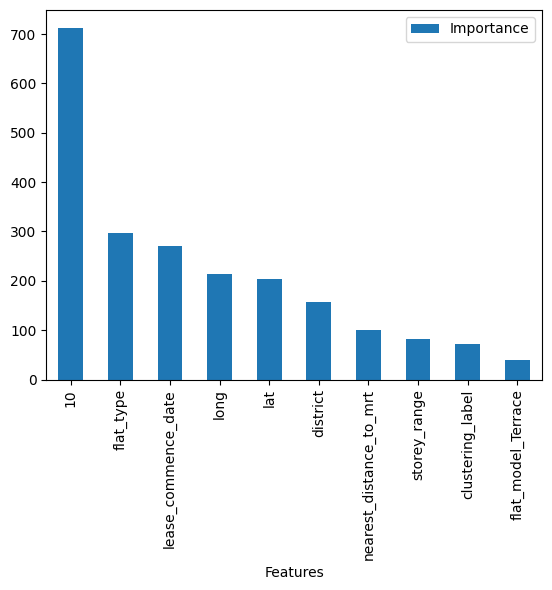

In [31]:
len(model.feature_importances_.tolist())
test_dict = {'Features': new_cols, 'Importance': model.feature_importances_.tolist()}
pd.DataFrame(test_dict).sort_values(by='Importance', ascending=False).iloc[:10,:]
pd.DataFrame(test_dict).sort_values(by='Importance', ascending=False).iloc[:10,:].plot(kind='bar',x = 'Features', y='Importance')

In [32]:
test_dict = {'Features': new_cols, 'Importance': model.feature_importances_.tolist()}

In [33]:
pd.DataFrame(test_dict).sort_values(by='Importance', ascending=False).iloc[:10,:]

,Features,Importance
214,10,713
211,flat_type,297
206,lease_commence_date,270
208,long,214
207,lat,204
212,district,157
209,nearest_distance_to_mrt,101
210,storey_range,83
213,clustering_label,73
55,flat_model_Terrace,39


<AxesSubplot: xlabel='Features'>

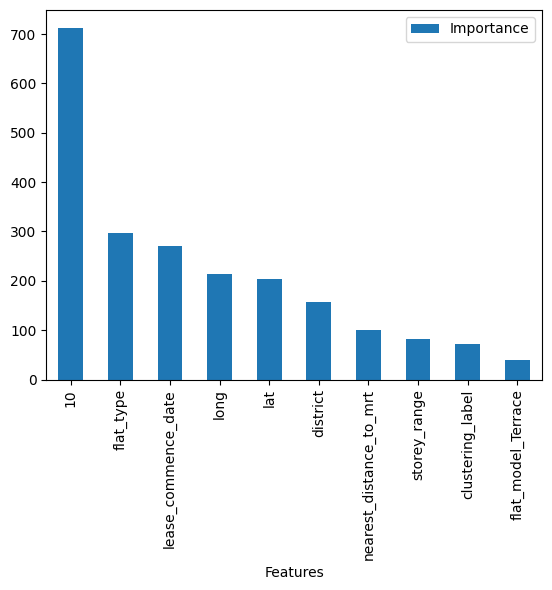

In [34]:
pd.DataFrame(test_dict).sort_values(by='Importance', ascending=False).iloc[:10,:].plot(kind='bar',x = 'Features', y='Importance')

In [35]:
params = {'max_bin': [300,350,400],
          'learning_rate': np.arange(0.1,0.5,0.2),
          'num_leaves': range(300,360,20),
         'random_state': [42]}

gridsearchcv = GridSearchCV(model,param_grid = params, scoring = 'neg_mean_squared_error', cv=3)

gridsearchcv.fit(X_transformed,y)

GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=42),
             param_grid={'learning_rate': array([0.1, 0.3]),
                         'max_bin': [300, 350, 400],
                         'num_leaves': range(300, 360, 20),
                         'random_state': [42]},
             scoring='neg_mean_squared_error')

In [36]:
isinstance(gridsearchcv, GridSearchCV)
gridsearchcv.best_estimator_.feature_importances_

array([  48,  234,   85,   18,   41,   74,   59,   79,   26,   61,   69,
         18,   17,  102,    0,   81,   23,   19,   75,    9,   41,   79,
         32,   53,   52,   22,    0,   37,   79,  128,   77,   94,    0,
        308,    0,   37,  131,   39,    2,  139,  352,   79,   24,   22,
         52,  119,    0,  170,   22,    0,   84,   85,  120,  152,   52,
         98,    1,    2,  154,  164,  140,  133,  180,  214,  270,  310,
        293,  326,  388,   10,  131,   10,    0,   13,    5,   83,   32,
         15,    0,    1,  132,   42,   15,    0,   21,   16,   22,   28,
          3,   79,   15,   33,   19,    0,    8,    3,   14,    0,    9,
         27,    0,   16,   33,   20,   24,    4,    4,    3,   16,    0,
         34,   37,    3,   26,    0,    9,   21,    0,    6,   25,   29,
         38,   22,    7,   11,   49,    6,   62,   18,   13,   11,   51,
         56,    4,   50,    1,    0,   31,    7,    3,    1,   27,   35,
         15,   31,   11,   17,    1,   55,    1,   

In [37]:
new_cols = []

for pipeline in datapipe.transformers_:
    cols = pipeline[2]
    cat = pipeline[1]

    if isinstance(cat, OneHotEncoder):
        cols = pipeline[1].get_feature_names_out().tolist()
    
    new_cols += cols

In [38]:
len(new_cols)

215

In [39]:
new_cols

['town_BEDOK',
 'town_BISHAN',
 'town_BUKIT BATOK',
 'town_BUKIT MERAH',
 'town_BUKIT PANJANG',
 'town_BUKIT TIMAH',
 'town_CENTRAL AREA',
 'town_CHOA CHU KANG',
 'town_CLEMENTI',
 'town_GEYLANG',
 'town_HOUGANG',
 'town_JURONG EAST',
 'town_JURONG WEST',
 'town_KALLANG/WHAMPOA',
 'town_LIM CHU KANG',
 'town_MARINE PARADE',
 'town_PASIR RIS',
 'town_PUNGGOL',
 'town_QUEENSTOWN',
 'town_SEMBAWANG',
 'town_SENGKANG',
 'town_SERANGOON',
 'town_TAMPINES',
 'town_TOA PAYOH',
 'town_WOODLANDS',
 'town_YISHUN',
 'flat_model_2-room',
 'flat_model_APARTMENT',
 'flat_model_Adjoined flat',
 'flat_model_Apartment',
 'flat_model_DBSS',
 'flat_model_IMPROVED',
 'flat_model_IMPROVED-MAISONETTE',
 'flat_model_Improved',
 'flat_model_Improved-Maisonette',
 'flat_model_MAISONETTE',
 'flat_model_MODEL A',
 'flat_model_MODEL A-MAISONETTE',
 'flat_model_MULTI GENERATION',
 'flat_model_Maisonette',
 'flat_model_Model A',
 'flat_model_Model A-Maisonette',
 'flat_model_Model A2',
 'flat_model_Multi Generation

<AxesSubplot: xlabel='Features'>

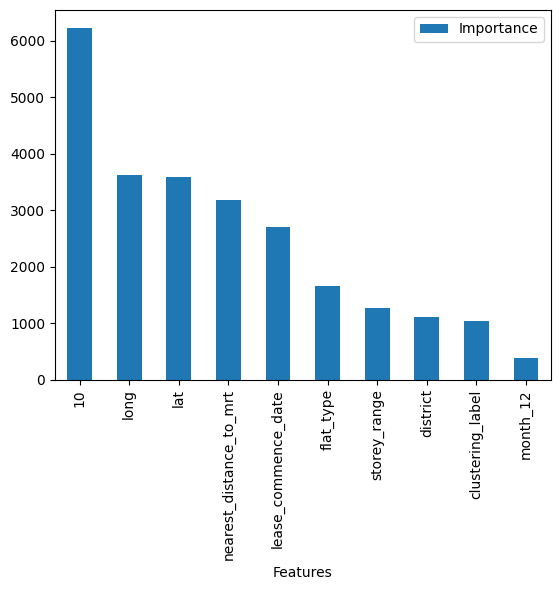

In [40]:
len(gridsearchcv.best_estimator_.feature_importances_.tolist())
test_dict = {'Features': new_cols, 'Importance': gridsearchcv.best_estimator_.feature_importances_.tolist()}
pd.DataFrame(test_dict).sort_values(by='Importance', ascending=False).iloc[:10,:]
pd.DataFrame(test_dict).sort_values(by='Importance', ascending=False).iloc[:10,:].plot(kind='bar',x = 'Features', y='Importance')

In [41]:
test_dict = {'Features': new_cols, 'Importance': gridsearchcv.best_estimator_.feature_importances_.tolist()}

In [42]:
pd.DataFrame(test_dict).sort_values(by='Importance', ascending=False).iloc[:10,:]

,Features,Importance
214,10,6235
208,long,3629
207,lat,3586
209,nearest_distance_to_mrt,3177
206,lease_commence_date,2706
211,flat_type,1652
210,storey_range,1268
212,district,1115
213,clustering_label,1046
68,month_12,388


<AxesSubplot: xlabel='Features'>

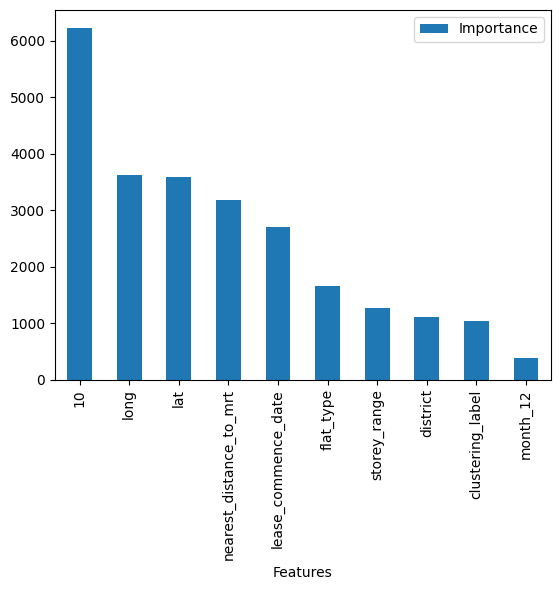

In [43]:
pd.DataFrame(test_dict).sort_values(by='Importance', ascending=False).iloc[:10,:].plot(kind='bar',x = 'Features', y='Importance')

In [45]:
best_model = gridsearchcv.best_estimator_

In [46]:
gridsearchcv.best_params_

{'learning_rate': 0.1, 'max_bin': 350, 'num_leaves': 340, 'random_state': 42}

In [47]:
# original took about 10 secs
train_rmse_list = []
val_rmse_list = []
cv = 10
model_cv_score = cross_validate(best_model,X_transformed, y, scoring = 'neg_mean_squared_error', 
cv=cv, n_jobs = -1,return_train_score= True )

train_rmse_list.append(model_cv_score['train_score'])
val_rmse_list.append(model_cv_score['test_score'])

metrics = {
    'Model': model,
    'Mean Train RMSE': ((-model_cv_score['train_score'])**(1/2)).mean(),
    'Train RMSE': list(model_cv_score['train_score']),
    'Val RMSE' : list(model_cv_score['test_score']),
    'Mean Val RMSE': ((-model_cv_score['test_score'])**(1/2)).mean()
}

print(metrics)

{'Model': LGBMRegressor(random_state=42), 'Mean Train RMSE': 18949.448476966012, 'Train RMSE': [-359121682.0701051, -361123492.3014294, -358822618.5732314, -359897022.7990229, -357681605.6544207, -360919579.5783122, -359202369.86779135, -359853312.1652063, -356477472.5672492, -357730374.7155751], 'Val RMSE': [-512334465.2024909, -479634158.26210165, -482744596.6989138, -495498242.6455615, -483504562.47149456, -476770257.3256751, -486455814.6990025, -504706285.686741, -483930994.1851895, -493814323.2501145], 'Mean Val RMSE': 22133.218146498533}


In [48]:
len(datapipe.transformers_)

5

In [49]:
len(datapipe.transformers)

4

In [50]:
datapipe.transformers_[4]

('remainder', 'passthrough', [10])

In [51]:
df_combined_geo.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
0,ANG MO KIO,3 ROOM,Improved,69.0,ANG MO KIO AVE 4,147000.0,2000-01,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
1,ANG MO KIO,3 ROOM,Improved,60.0,ANG MO KIO AVE 4,130000.0,2000-02,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
2,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,105000.0,2000-03,1986,04 TO 06,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
3,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,125000.0,2000-05,1986,04 TO 06,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
4,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,117000.0,2000-06,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283


In [52]:
from typing import Optional
from sklearn.preprocessing import StandardScaler , OneHotEncoder , PolynomialFeatures, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression , Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, VotingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.base import RegressorMixin
from pprint import pprint

import pickle
from typing import List, Union
import logging 

class Modelpipeline:
    """
    A pipeline to take in a pandas dataframe and has some configurables 
    to tailor the model or how the data would be preprocessed
    """
    def __init__(
        self, 
        dataset:pd.DataFrame,
        dimension_reduction:str = None,
        clustering:str = None,
        additional_features_out:List[str] = None,
        test_size:float=0.3,
        random_state:int=42,
        features_out:List[str] = ['street_name', 'lease_commence_date','block','address','full_address']
        ) -> None:
        dataset_copy = dataset.copy(deep= True)
        self.dataset = dataset_copy
        self.features_out = features_out
        self.ADDITIONAL_DROP_FEATURES = additional_features_out
        self.dimension_reduction = dimension_reduction
        self.clustering = clustering
        self.test_size = test_size
        self.random_state = random_state

        params_to_check = ['model','dimension_reduction','clustering']

        self.logger = logging.getLogger(__name__)

        # Check valid
        # for item in params_to_check:
        #     if self._check_valid(item, self.{item}) == False:
        #         raise SyntaxError('Incorrect value')

        self.dimension_reduction_model = PCA(n_components=0.95)
        self.clustering_model = DBSCAN(eps=1.5)
        self.logger.critical(f"Inspecting Dataframe \n Shape : {self.dataset.shape} \
            \n First Row : {self.dataset.head(1)} \n Columns : {self.dataset.columns}")

    def _check_valid(self,type:str,value:str)->bool:
        """Checks if the parameter is valid

        Args:
            type (str): Accepts model, dimension_reduction or clustering
            value (str): the value of the param, i.e if its model, then xgb, lgbm, etc

        Returns:
            bool: If params are valid
        """
        valid_list = {
            'model':['xgb','lgbm','lasso','linear_regression', 'ridge', 'elasticnet'],
            'dimension_reduction':['pca'],
            'clustering':['dbscan']
        }
        return value in valid_list[type]
        
    def _add_year(self, dataset:pd.DataFrame) -> None:
        """
        Adds the year feature into the dataset
        """
        try:
            dataset['year'] = pd.to_datetime(dataset['month']).dt.year
        except Exception as e:
            self.logger.critical(f"Unable to create year column due to error msg {e}")

    def _add_month(self, dataset:pd.DataFrame) -> None:
        """
        Adds the month feature from the existing month column,
        overwriting it
        """
        try:
            dataset['month'] = pd.to_datetime(dataset['month']).dt.month
        except Exception as e:
            self.logger.critical(f"Unable to change month column due to error msg {e}")

    def _add_district(self, dataset:pd.DataFrame) -> None:
        """
        Adds the district feature using the full_address column by taking
        the first 2 digits of the postal code in the full address. Fills na with 0
        """
        try:
            dataset['district'] = dataset['full_address'].apply(lambda x:x[-6:-4])
            dataset['district'] = pd.to_numeric(dataset['district'], errors='coerce')
            dataset['district'].fillna(0, axis=0, inplace=True)
            dataset['district'] = dataset['district'].astype(int)
        except Exception as e:
            self.logger.critical(f"Unable to add district column due to error msg {e}")
    
    def _add_features(self, dataset:pd.DataFrame) -> None:
        """
        Adds all of the features
        """
        self._add_year(dataset)
        self._add_month(dataset)
        self._add_district(dataset)

    def _convert_features(self, dataset:pd.DataFrame) -> None:
        """
        convert features from the dataset and replaces some text due to consistency issue
        """
        dataset['remaining_lease'] = dataset['remaining_lease'].astype(str).str[:2].astype(int)
        dataset['floor_area_sqm'] = dataset['floor_area_sqm'].astype(float)
        dataset['resale_price'] = dataset['resale_price'].astype(float)
        dataset['flat_type'] = dataset['flat_type'].str.replace('MULTI-GENERATION','MULTI GENERATION')

    def _drop_features_pipeline(self, which_features:List[str])->None:
        """
        Drop the features from the pipeline category
        """

        for feature_category in self.FEATURES_LIST:
            relevant_features = [feature for feature in feature_category if feature in \
                which_features]
            for feature in relevant_features:
                feature_category.remove(feature)


    def _dimension_reduction(self)->pd.DataFrame:
        """
        Uses the selected dimension reduction technique and replaces the original features
        with them
        """
        pass

    def _clustering_feature(self)->None:
        """
        Adds clustering label as feature after reducing dimensions
        """
        # PCA only takes in numerical values
        dataset_numerical = self.dataset.select_dtypes(exclude = 'object').loc[:, self.dataset.select_dtypes(exclude = 'object').columns != self.TARGET]
        dataset_dim_reduced = self.dimension_reduction_model.fit_transform(dataset_numerical)

        self.logger.critical(list(zip(["pca " + str(idx) for idx in \
            range(1,len(self.dimension_reduction_model.explained_variance_ratio_))] ,
            self.dimension_reduction_model.explained_variance_ratio_)))

        self.clustering_model.fit(dataset_dim_reduced)

        labels = self.clustering_model.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        self.logger.critical(f"Estimated number of clusters: {n_clusters_}")
        self.logger.critical(f"Estimated number of noise points: {n_noise_}")

        self.dataset['clustering_label'] = labels

    def _clustering_predict(self, inputs) ->pd.DataFrame:
        """
        Uses Kmeans to classify the inputs with the trained
        DBSCAN algorithm
        """
        from sklearn.neighbors import KNeighborsClassifier

        knn = KNeighborsClassifier(n_neighbors=50)
        knn.fit(self.clustering_model.components_,
        self.clustering_model.labels[self.clustering_model.core_sample_indicies_])
        knn_labels = knn.predict(inputs)
        self.logger.critical(f"knn_labels: {knn_labels}")
        inputs['clustering_label'] = knn_labels

        return inputs


    def _pre_process(self)->None:
        """
        Prepares the dataset by adding, dropping, transforming features before
        splitting and training
        """

        self._add_features(self.dataset)
        self._convert_features(self.dataset)
        
        self.TARGET = "resale_price"
        self.NUM_FEATURES = self.dataset.select_dtypes(include=['float','int']).columns.tolist()
        self.NUM_FEATURES.remove(self.TARGET)
        self.DROP_FEATURES = ['street_name','block','address','full_address']
        self.ORDINAL_FEATURES = ["storey_range", "flat_type"]
        self.CAT_FEATURES = self.dataset.select_dtypes(exclude=['float','int']).columns.tolist()
        self.CAT_FEATURES = [feature for feature in self.CAT_FEATURES if feature not in self.ORDINAL_FEATURES]
        self.NEW_FEATURES = ['district']

        if self.dimension_reduction:
            self.NEW_FEATURES.append('clustering_label')

        self.TOTAL_FEATURES = self.dataset.columns.tolist() + self.NEW_FEATURES
        self.FEATURES = self.NUM_FEATURES + [self.TARGET] + self.CAT_FEATURES + self.ORDINAL_FEATURES + self.NEW_FEATURES
        self.FEATURES_LIST = [self.NUM_FEATURES, self.CAT_FEATURES, self.ORDINAL_FEATURES, self.NEW_FEATURES]
        assert len(self.TOTAL_FEATURES) == len(self.FEATURES)

        if len(self.features_out) !=0:
            # drop from pipeline
            self._drop_features_pipeline(self.features_out)
            # drop from dataset
            self.dataset.drop(columns=self.features_out, inplace=True)
        
        if self.ADDITIONAL_DROP_FEATURES:
            # drop from pipeline
            self._drop_features_pipeline(self.ADDITIONAL_DROP_FEATURES)
            # drop from dataset
            self.dataset.drop(columns=self.ADDITIONAL_DROP_FEATURES, inplace=True)

        if self.dimension_reduction:
            self._dimension_reduction()
        
        if self.clustering:
            self._clustering_feature()
        

    def _transform(self, dataset) -> np.array:
        """
        transforms the dataset by using the datapipe
        """
        dataset_transformed = self.datapipe.transform(dataset)

        return dataset_transformed

    def _fit(self, dataset)-> None:
        """
        Fits the datapipe with the dataset
        """

        ordinal_ranking_flat_type = ['MULTI GENERATION','EXECUTIVE', '5 ROOM','4 ROOM', '3 ROOM','2 ROOM', '1 ROOM']
        ordinal_ranking_storey_range = [ '01 TO 03','01 TO 05','04 TO 06', '06 TO 10', '07 TO 09', 
        '10 TO 12','11 TO 15', '13 TO 15','16 TO 18','16 TO 20','19 TO 21','21 TO 25', '22 TO 24', 
        '25 TO 27', '26 TO 30', '28 TO 30','31 TO 33','31 TO 35','34 TO 36','37 TO 39', '36 TO 40', 
        '40 TO 42', '43 TO 45', '46 TO 48','49 TO 51']

        self.ordinal_pipe = OrdinalEncoder(categories=[ordinal_ranking_storey_range,ordinal_ranking_flat_type])
        self.cat_pipe = OneHotEncoder(drop='first', sparse=False)
        self.num_pipe = StandardScaler()
        self.simpleimputer = SimpleImputer(strategy="median")

        self.datapipe = ColumnTransformer([
            ('cat_pipe',self.cat_pipe , self.CAT_FEATURES),
            ('num_pipe',self.num_pipe, self.NUM_FEATURES),
            ('ordinal_pipe', self.ordinal_pipe, self.ORDINAL_FEATURES),
            ('imputer', self.simpleimputer, self.NEW_FEATURES)
            ], remainder='passthrough')

        self.datapipe.fit(dataset)
    

    def fit_transform(self, dataset)-> np.array:
        """
        Fits and transforms the dataset with the datapipe
        """
        self._fit(dataset)
        dataset_transformed = self._transform(dataset)

        return dataset_transformed

    def preprocess(self, training_size:float=1, split:bool = True)->None:
        """
        Main function to preprocess the dataset and splits the datset
        """

        ############################################################
        # preps the dataset, adding, dropping features , etc
        ############################################################
        self._pre_process()

        self.logger.critical(f"Inspect dataset: {self.dataset.head()} \n \
            Columns : {self.dataset.columns}")

        ##############################
        # Seperates X and y
        ##############################
        if training_size !=1:
            training_samples = int(len(self.dataset)*training_size)
            y = self.dataset.resale_price.sample(training_samples, random_state = self.random_state)
            X = self.dataset.loc[:, self.dataset.columns != 'resale_price'].sample(training_samples, random_state = self.random_state)


        else:
            y = self.dataset.resale_price
            X = self.dataset.loc[:, self.dataset.columns != 'resale_price'] 

        if split == False:
            self.X_train, X_test, self.y_train, y_test= train_test_split(X, y,test_size=self.test_size, random_state=self.random_state)
            self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(X_test, y_test,test_size=0.5, random_state=self.random_state)
        else:
            self.X_train = X
            self.y_train = y

        self.X_transformed = self.fit_transform(self.X_train)
        self.logger.info(f"Shape of X transformed training set: {self.X_transformed.shape}")

        

    def train_model(self, model:Union[str, RegressorMixin])->None:
        """
        Trains the model
        """

        available_models = {
            'lgbm':lgb.LGBMRegressor(random_state = self.random_state),
            'xgb': xgb.XGBRegressor(random_state=self.random_state),
            'lr': LinearRegression(),
            'lasso': Lasso(),
            'ridge' : Ridge(),
            'elasticnet': ElasticNet(),
            'randomforest': RandomForestRegressor(random_state=self.random_state),
            'decisiontree': DecisionTreeRegressor(random_state=self.random_state),
            'sgd' : SGDRegressor()
        }

        if isinstance(model, str):
            self.model = available_models[model]
        elif isinstance(model, RegressorMixin):
            self.model = model
        else:
            raise TypeError("Please either pass in a string or a Regression Estimator")

        self.model.fit(self.X_transformed, self.y_train)

    def report_metrics(self, cv :int = 10)->dict:
        """
        Returns metrics for the chosen model in a dictionary
        """
        train_rmse_list = []
        val_rmse_list = []
        cv = cv
        model_cv_score = cross_validate(self.model,self.X_transformed, self.y_train, scoring = 'neg_mean_squared_error', 
        cv=cv, n_jobs = -1,return_train_score= True )
        
        train_rmse_list.append(model_cv_score['train_score'])
        val_rmse_list.append(model_cv_score['test_score'])
        
        self.metrics = {
            'Model': self.model,
            'Mean Train RMSE': ((-model_cv_score['train_score'])**(1/2)).mean(),
            'Train MSE': model_cv_score['train_score'].tolist(),
            'Val MSE' : model_cv_score['test_score'].tolist(),
            'Mean Val RMSE': ((-model_cv_score['test_score'])**(1/2)).mean()
        }

        metrics_to_print = {
            'Model': self.model,
            'Mean Train RMSE': f"{((-model_cv_score['train_score'])**(1/2)).mean():,}",
            'Mean Val RMSE': f"{((-model_cv_score['test_score'])**(1/2)).mean():,}"
            # 'Train RMSE': [f"{(-number)**(1/2):,}" for number in model_cv_score['train_score'].tolist()],
            # 'Val RMSE' : [f"{(-number)**(1/2):,}" for number in model_cv_score['test_score'].tolist()]
        }

        pprint(metrics_to_print)
        self.plot_results(model_cv_score, str(self.model))

    def report_best_features(self, plot:bool = False)->Optional[dict]:
        """
        Returns a dictionary with the best features and its importance
        Using model's inbuilt feature or Lasso if unavailable 
        """
        new_cols = []

        for pipeline in self.datapipe.transformers_:
            cols = pipeline[2]
            cat = pipeline[1]

            if isinstance(cat, OneHotEncoder):
                cols = pipeline[1].get_feature_names_out().tolist()
            
            new_cols += cols

        # self.logger.critical(f"Feature importance: {self.model.feature_importances_.tolist()}")
        # self.logger.critical(f"New Cols: {new_cols}")

        feature_importance = self.model.feature_importances_.tolist()
        assert len(feature_importance) == len(new_cols)
        res = {'Features': new_cols, 'Importance': feature_importance}
        if plot == False:
            return res
        else:
            pd.DataFrame(res).sort_values(by='Importance', ascending=False).iloc[:10,:].plot(kind='bar',x = 'Features', \
                y='Importance', title= f"Feature Importance of {self.model}" )

    def tune(self, params:dict, cv:int = 3)-> None:
        """
        Perform hyperparameter tunning for the model
        """

        gridsearchcv = GridSearchCV(self.model,param_grid = params, scoring = 'neg_mean_squared_error', cv=cv)

        gridsearchcv.fit(self.X_transformed, self.y_train)
        self.model = gridsearchcv.best_estimator_
        self.logger.critical(f"Training done, best params: {gridsearchcv.best_params_}")

    def _pre_process_prediction(self, inputs:pd.DataFrame)-> pd.DataFrame:
        """
        Prepares the input by adding, dropping, transforming features before
        running inference
        """

        self._add_features(inputs)
        self._convert_features(inputs)
        
        # dont need these guys for inference

        # self.TARGET = "resale_price"
        # self.NUM_FEATURES = self.dataset.select_dtypes(include=['float','int']).columns.tolist()
        # self.NUM_FEATURES.remove(self.TARGET)
        # self.DROP_FEATURES = ['street_name','block','address','full_address']
        # self.ORDINAL_FEATURES = ["storey_range", "flat_type"]
        # self.CAT_FEATURES = self.dataset.select_dtypes(exclude=['float','int']).columns.tolist()
        # self.CAT_FEATURES = [feature for feature in self.CAT_FEATURES if feature not in self.ORDINAL_FEATURES]
        # self.NEW_FEATURES = ['district']

        # if self.dimension_reduction:
        #     self.NEW_FEATURES.append('clustering_label')

        # self.TOTAL_FEATURES = self.dataset.columns.tolist() + self.NEW_FEATURES
        # self.FEATURES = self.NUM_FEATURES + [self.TARGET] + self.CAT_FEATURES + self.ORDINAL_FEATURES + self.NEW_FEATURES
        # self.FEATURES_LIST = [self.NUM_FEATURES, self.CAT_FEATURES, self.ORDINAL_FEATURES, self.NEW_FEATURES]
        # assert len(self.TOTAL_FEATURES) == len(self.FEATURES)

        if len(self.features_out) !=0:
            # drop from dataset
            inputs.drop(columns=self.features_out, inplace=True)
        
        if self.ADDITIONAL_DROP_FEATURES:
            # drop from dataset
            inputs.drop(columns=self.ADDITIONAL_DROP_FEATURES, inplace=True)

        if self.dimension_reduction:
            self._dimension_reduction()
        
        if self.clustering:
            inputs = self._clustering_predict(inputs)

        return inputs

    def _preprocess_prediction_raw(self, input:pd.DataFrame)->pd.DataFrame:
        """
        Preprocess prediction input from user with minimal information

        User will need to provide only the following data for inference:
        - Postal Code
        - Flat-type
        - Storey-range
        - Town

        in order to provide the following
        - nearest_mrt
        - flat_model
        - floor area sqm
        - year, month : fixed to current year and month
        - lat, long
        - full address

        
        """

        pass


    def predict(self, inputs:pd.DataFrame)-> Union[float,List[float]]:
        """
        Using the model to predict either batch or single data
        Returns either a list of predictions or a single prediction
        """
        self.logger.critical(f"Input: {inputs}")
        # adds , remove features
        processed_inputs = self._pre_process_prediction(inputs)
        
        try:
            inputs_transformed = self.datapipe.transform(processed_inputs)
            self.logger.critical(f"Input transformed: {inputs_transformed}")      
            pred = self.model.predict(inputs_transformed)

            return pred
        except Exception as e:
            self.logger.critical(f"Unable to generate prediction due to msg: {e}")



    def plot_results(self, score, title):
        
        train_score = score['train_score']
        test_score = score['test_score']
        
        train_score = (-train_score)**(1/2) 
        test_score = (-test_score)**(1/2)
        
        cv = len(score['score_time'])
        
        fig, ax = plt.subplots(figsize = (5,5))
        
        ax.plot(range(cv), train_score, 'r-', label = 'Training RMSE');
        ax.plot(range(cv), test_score, 'b--', label = 'Validation RMSE');
        ax.set_title(title)
        ax.set_xlabel('K-Folds')
        ax.set_ylabel('Error')
        ax.legend()
        plt.show()

    def save_model(self, title):
        """
        saved model in path
        """
        pickle.dump(self.model, open(f"{title}.pkl",'wb'))
    
    def load_model(self, model_path):
        """
        loads model from path
        """
        with open(model_path, 'rb') as f:
            self.model = pickle.load(f)
        


In [53]:
df_test = df_combined_geo.copy(deep = True)

In [54]:
df_test.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
0,ANG MO KIO,3 ROOM,Improved,69.0,ANG MO KIO AVE 4,147000.0,2000-01,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
1,ANG MO KIO,3 ROOM,Improved,60.0,ANG MO KIO AVE 4,130000.0,2000-02,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
2,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,105000.0,2000-03,1986,04 TO 06,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
3,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,125000.0,2000-05,1986,04 TO 06,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
4,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,117000.0,2000-06,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283


As a baseline, we remove features that were not introduced in the original dataset which are the coordinates (lat and long), district from the postal code retrieved from the full address and the distance to MRTs.

In [55]:
modelpipe_base = Modelpipeline(df_test,additional_features_out=['lat','long', 'nearest_mrt', 'nearest_distance_to_mrt','district'])
modelpipe_base.preprocess(training_size=0.5, split=False)

Inspecting Dataframe 
 Shape : (880195, 17)             
 First Row :          town flat_type flat_model  floor_area_sqm       street_name  \
0  ANG MO KIO    3 ROOM   Improved            69.0  ANG MO KIO AVE 4   

   resale_price    month  lease_commence_date storey_range block  \
0      147000.0  2000-01                 1986     07 TO 09   170   

  remaining_lease               address  \
0              85  170 ANG MO KIO AVE 4   

                                        full_address       lat        long  \
0  170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...  1.374001  103.836432   

  nearest_mrt  nearest_distance_to_mrt  
0   mayflower                    0.283   
 Columns : Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')
Inspect dataset

{'Mean Train RMSE': '32,053.472997119698',
 'Mean Val RMSE': '32,363.088527159358',
 'Model': LGBMRegressor(random_state=42)}


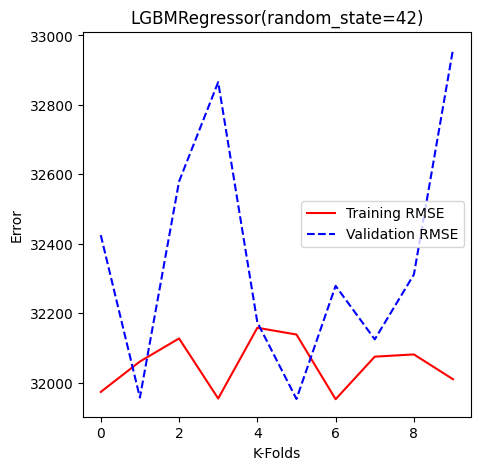

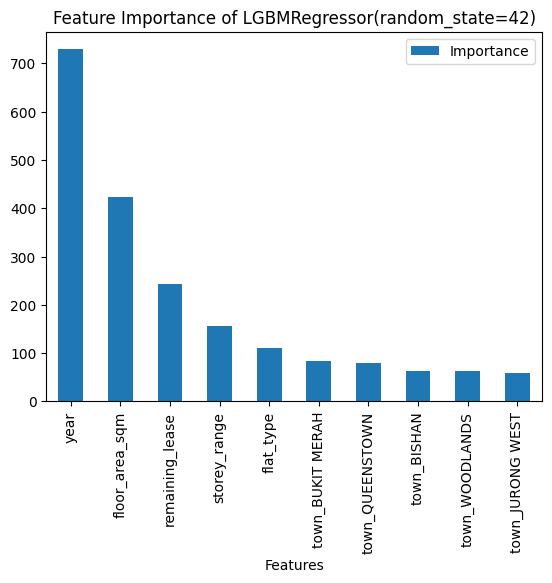

In [56]:
modelpipe_base.train_model('lgbm')
modelpipe_base.report_metrics()
modelpipe_base.report_best_features(plot=True)

In the baseline dataset, year appears to be the feature that is the most important by a wide margin, followed by the floor area, the remaining lease, storey range and lastly the flat type. Beyond that we see certain towns that I think mostly have quite pricely flats like Bukit Merah, Queenstown and Bishan.

Year makes sense because as we have seen in the price trend, as the year progresses the average price increases.

It also makes sense for the next four features. The larger the floor area, the longer the remaining lease, the higher the level of the flat tends to command higher flat prices. Likewise a 5 room flat correlates to the floor area. All of the feature importance makes sense

### Features to test
- New Features
- Date component
- Clustering labels
- Lat, Long
- Nearest_distance to MRT

Inspecting Dataframe 
 Shape : (880195, 17)             
 First Row :          town flat_type flat_model  floor_area_sqm       street_name  \
0  ANG MO KIO    3 ROOM   Improved            69.0  ANG MO KIO AVE 4   

   resale_price    month  lease_commence_date storey_range block  \
0      147000.0  2000-01                 1986     07 TO 09   170   

  remaining_lease               address  \
0              85  170 ANG MO KIO AVE 4   

                                        full_address       lat        long  \
0  170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...  1.374001  103.836432   

  nearest_mrt  nearest_distance_to_mrt  
0   mayflower                    0.283   
 Columns : Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')
Inspect dataset

{'Mean Train RMSE': '26,442.248449321127',
 'Mean Val RMSE': '26,796.25677717178',
 'Model': LGBMRegressor(random_state=42)}


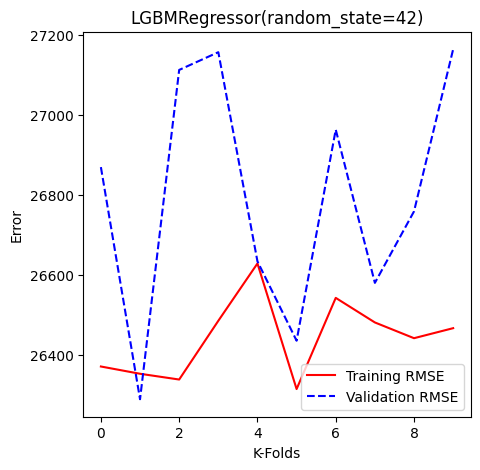

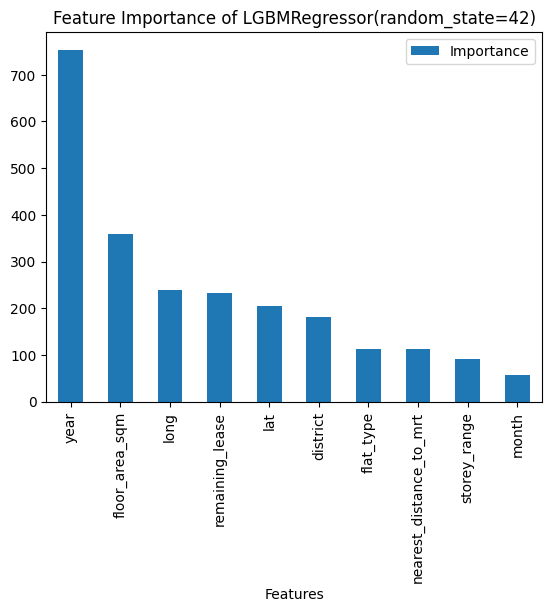

In [57]:
modelpipe = Modelpipeline(df_test)
modelpipe.preprocess(training_size=0.5, split=False)
modelpipe.train_model('lgbm')
modelpipe.report_metrics()
modelpipe.report_best_features(plot=True)

Now we introduce the the new features and error has dropped around 6K and the feature importances has changed.

Previously remaining lease, flat type and storey range were higher, within the top 5 but now new features have overtaken some slots.

Among the top ten features, year is still the number one feature and floor area is still the number two feature.

I see the coordinates along with district encapsulates the same idea of geolocation but long and lat is more precise.

One of the new feature which is the distance to MRT also appears in the top ten features which I think is a good addition. This confirms my suspicision that distance to mrt is also an important factor in determining the price of the resale flat.

Inspecting Dataframe 
 Shape : (880195, 17)             
 First Row :          town flat_type flat_model  floor_area_sqm       street_name  \
0  ANG MO KIO    3 ROOM   Improved            69.0  ANG MO KIO AVE 4   

   resale_price    month  lease_commence_date storey_range block  \
0      147000.0  2000-01                 1986     07 TO 09   170   

  remaining_lease               address  \
0              85  170 ANG MO KIO AVE 4   

                                        full_address       lat        long  \
0  170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...  1.374001  103.836432   

  nearest_mrt  nearest_distance_to_mrt  
0   mayflower                    0.283   
 Columns : Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')
Inspect dataset

{'Mean Train RMSE': '61,857.15188368903',
 'Mean Val RMSE': '62,331.965578034135',
 'Model': LGBMRegressor(random_state=42)}


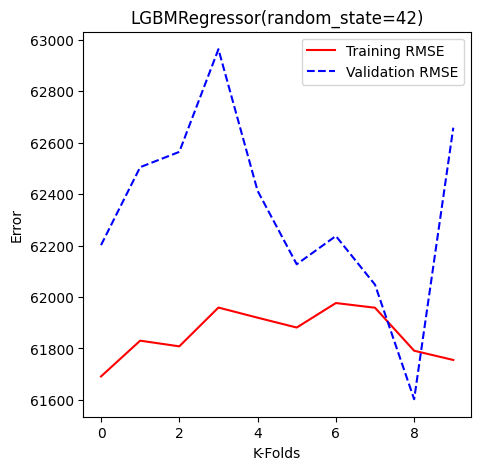

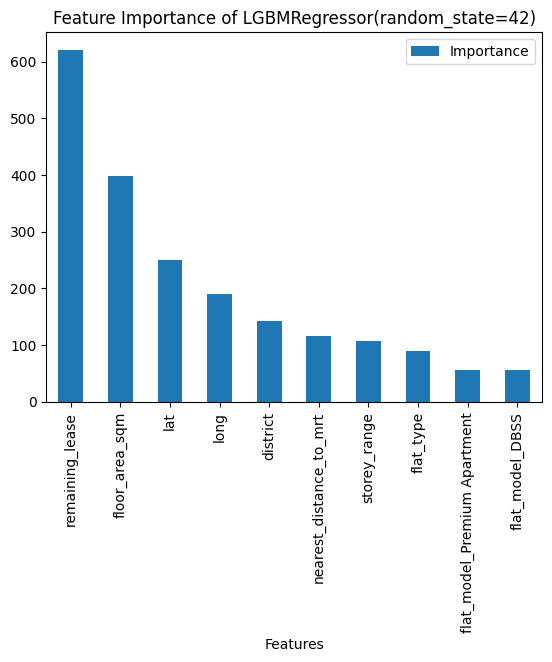

In [58]:
modelpipe_nodates = Modelpipeline(df_test,additional_features_out=['year','month'])
modelpipe_nodates.preprocess(training_size=0.5, split=False)
modelpipe_nodates.train_model('lgbm')
modelpipe_nodates.report_metrics()
modelpipe_nodates.report_best_features(plot=True)

Removing the year pretty much moves everything else up in importance but crucially the model takes a big hit in performance.

Inspecting Dataframe 
 Shape : (880195, 17)             
 First Row :          town flat_type flat_model  floor_area_sqm       street_name  \
0  ANG MO KIO    3 ROOM   Improved            69.0  ANG MO KIO AVE 4   

   resale_price    month  lease_commence_date storey_range block  \
0      147000.0  2000-01                 1986     07 TO 09   170   

  remaining_lease               address  \
0              85  170 ANG MO KIO AVE 4   

                                        full_address       lat        long  \
0  170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...  1.374001  103.836432   

  nearest_mrt  nearest_distance_to_mrt  
0   mayflower                    0.283   
 Columns : Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')
Inspect dataset

{'Mean Train RMSE': '27,193.140247934847',
 'Mean Val RMSE': '27,527.35458428982',
 'Model': LGBMRegressor(random_state=42)}


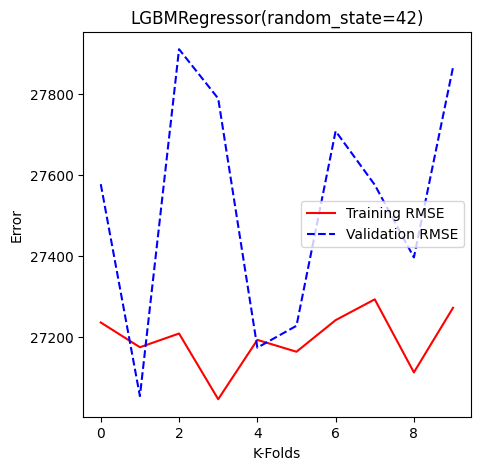

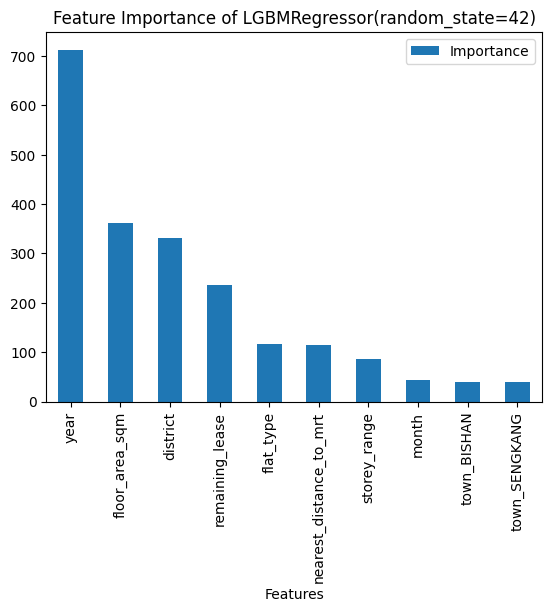

In [59]:
modelpipe_no_coordinates = Modelpipeline(df_test,additional_features_out=['lat','long'])
modelpipe_no_coordinates.preprocess(training_size=0.5, split=False)
modelpipe_no_coordinates.train_model('lgbm')
modelpipe_no_coordinates.report_metrics()
modelpipe_no_coordinates.report_best_features(plot=True)

Inspecting Dataframe 
 Shape : (880195, 17)             
 First Row :          town flat_type flat_model  floor_area_sqm       street_name  \
0  ANG MO KIO    3 ROOM   Improved            69.0  ANG MO KIO AVE 4   

   resale_price    month  lease_commence_date storey_range block  \
0      147000.0  2000-01                 1986     07 TO 09   170   

  remaining_lease               address  \
0              85  170 ANG MO KIO AVE 4   

                                        full_address       lat        long  \
0  170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...  1.374001  103.836432   

  nearest_mrt  nearest_distance_to_mrt  
0   mayflower                    0.283   
 Columns : Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')
Inspect dataset

{'Mean Train RMSE': '27,457.087763116848',
 'Mean Val RMSE': '27,777.798512329093',
 'Model': LGBMRegressor(random_state=42)}


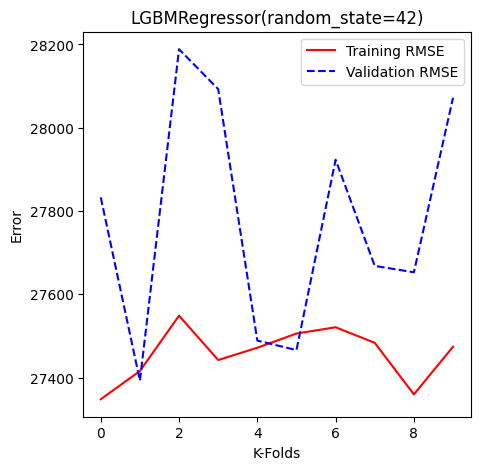

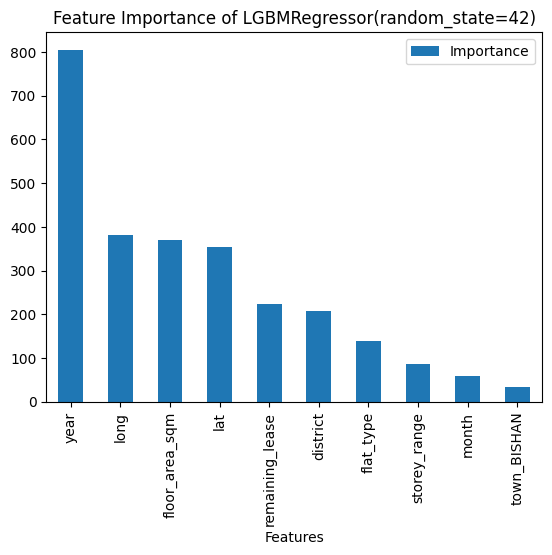

In [60]:
modelpipe_no_mrt = Modelpipeline(df_test,additional_features_out=['nearest_mrt','nearest_distance_to_mrt'])
modelpipe_no_mrt.preprocess(training_size=0.5, split=False)
modelpipe_no_mrt.train_model('lgbm')
modelpipe_no_mrt.report_metrics()
modelpipe_no_mrt.report_best_features(plot=True)

Removing the MRT features or lat and long appears to increase the error of the model slightly, upping about 1k in the validation RMSE. 

Inspecting Dataframe 
 Shape : (880195, 17)             
 First Row :          town flat_type flat_model  floor_area_sqm       street_name  \
0  ANG MO KIO    3 ROOM   Improved            69.0  ANG MO KIO AVE 4   

   resale_price    month  lease_commence_date storey_range block  \
0      147000.0  2000-01                 1986     07 TO 09   170   

  remaining_lease               address  \
0              85  170 ANG MO KIO AVE 4   

                                        full_address       lat        long  \
0  170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...  1.374001  103.836432   

  nearest_mrt  nearest_distance_to_mrt  
0   mayflower                    0.283   
 Columns : Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')
[('pca 1', 0.60

{'Mean Train RMSE': '26,483.078638724062',
 'Mean Val RMSE': '26,841.702663658412',
 'Model': LGBMRegressor(random_state=42)}


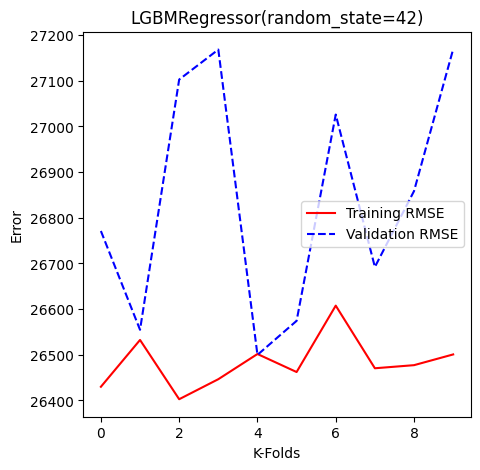

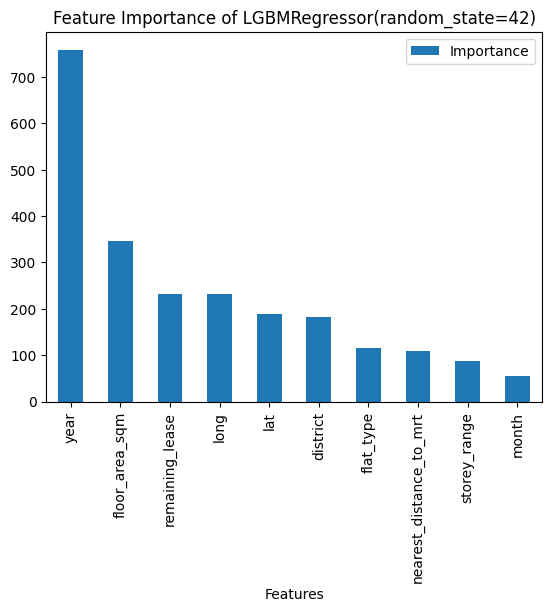

In [61]:
modelpipe_dbscan = Modelpipeline(df_test,clustering='dbscan')
modelpipe_dbscan.preprocess(training_size=0.5, split=False)
modelpipe_dbscan.train_model('lgbm')
modelpipe_dbscan.report_metrics()
modelpipe_dbscan.report_best_features(plot=True)

Let's see if by adding a cluster label will aid in the prediction. Unfortunately it does not appear to be a good feature as it helped decrease validation RMSE by 50 which is negligible.

In [62]:
modelpipe = Modelpipeline(df_test,'pca','dbscan')
modelpipe.preprocess(training_size=0.5, split=False)

Inspecting Dataframe 
 Shape : (880195, 17)             
 First Row :          town flat_type flat_model  floor_area_sqm       street_name  \
0  ANG MO KIO    3 ROOM   Improved            69.0  ANG MO KIO AVE 4   

   resale_price    month  lease_commence_date storey_range block  \
0      147000.0  2000-01                 1986     07 TO 09   170   

  remaining_lease               address  \
0              85  170 ANG MO KIO AVE 4   

                                        full_address       lat        long  \
0  170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...  1.374001  103.836432   

  nearest_mrt  nearest_distance_to_mrt  
0   mayflower                    0.283   
 Columns : Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')
[('pca 1', 0.60

{'Mean Train RMSE': '26,483.078638724062',
 'Mean Val RMSE': '26,841.702663658412',
 'Model': LGBMRegressor(random_state=42)}


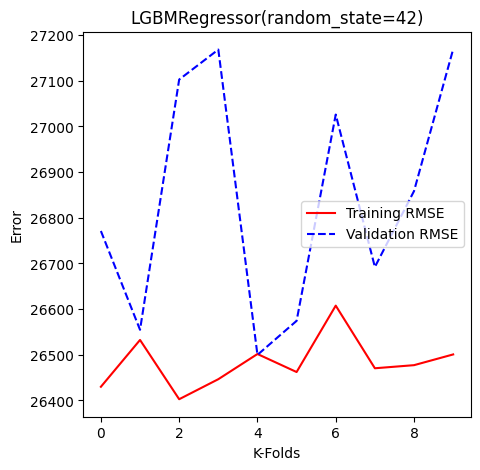

In [63]:
modelpipe.train_model('lgbm')
modelpipe.report_metrics()

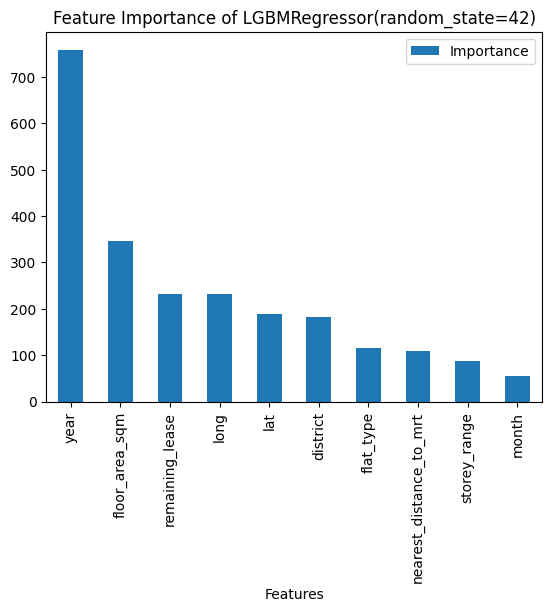

In [64]:
modelpipe.report_best_features(plot=True)

In [65]:
modelpipe_notown = Modelpipeline(df_test,'pca','dbscan', additional_features_out=['town'])
modelpipe_notown.preprocess(training_size=0.5, split=False)

Inspecting Dataframe 
 Shape : (880195, 17)             
 First Row :          town flat_type flat_model  floor_area_sqm       street_name  \
0  ANG MO KIO    3 ROOM   Improved            69.0  ANG MO KIO AVE 4   

   resale_price    month  lease_commence_date storey_range block  \
0      147000.0  2000-01                 1986     07 TO 09   170   

  remaining_lease               address  \
0              85  170 ANG MO KIO AVE 4   

                                        full_address       lat        long  \
0  170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...  1.374001  103.836432   

  nearest_mrt  nearest_distance_to_mrt  
0   mayflower                    0.283   
 Columns : Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')
[('pca 1', 0.60

{'Mean Train RMSE': '26,488.11054710042',
 'Mean Val RMSE': '26,849.42391521215',
 'Model': LGBMRegressor(random_state=42)}


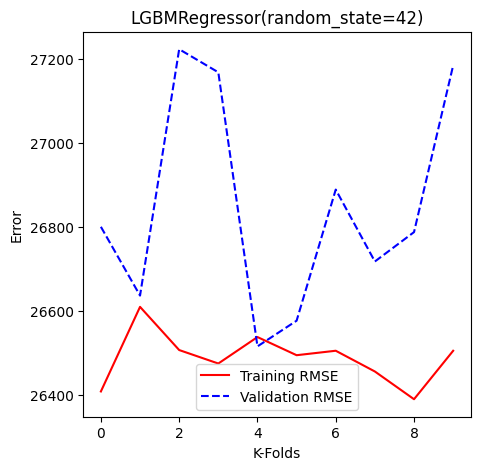

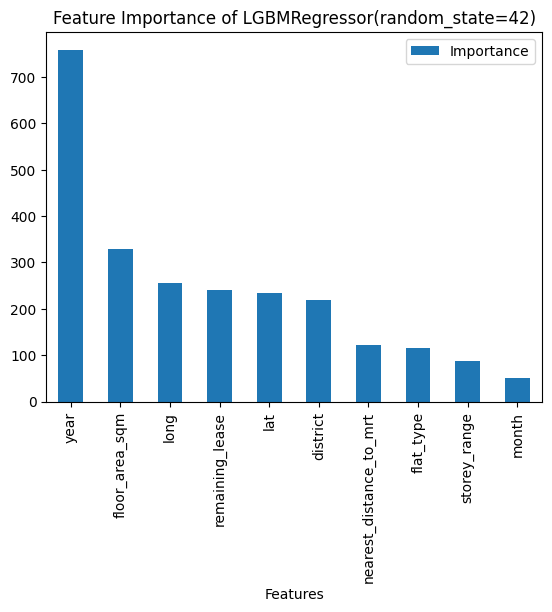

In [66]:
modelpipe_notown.train_model('lgbm')
modelpipe_notown.report_metrics()
modelpipe_notown.report_best_features(plot=True)

Inspecting Dataframe 
 Shape : (880195, 17)             
 First Row :          town flat_type flat_model  floor_area_sqm       street_name  \
0  ANG MO KIO    3 ROOM   Improved            69.0  ANG MO KIO AVE 4   

   resale_price    month  lease_commence_date storey_range block  \
0      147000.0  2000-01                 1986     07 TO 09   170   

  remaining_lease               address  \
0              85  170 ANG MO KIO AVE 4   

                                        full_address       lat        long  \
0  170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...  1.374001  103.836432   

  nearest_mrt  nearest_distance_to_mrt  
0   mayflower                    0.283   
 Columns : Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')
[('pca 1', 0.65

{'Mean Train RMSE': '27,875.612584529164',
 'Mean Val RMSE': '28,210.699053785975',
 'Model': LGBMRegressor(random_state=42)}


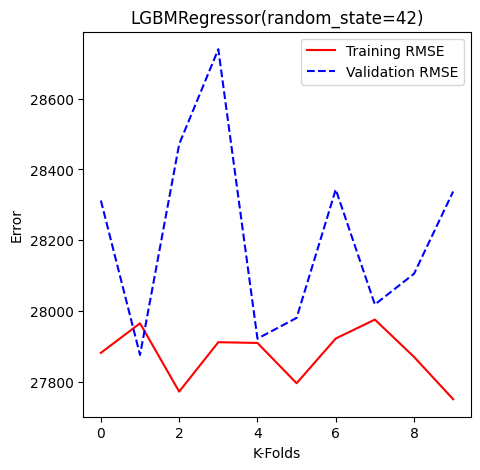

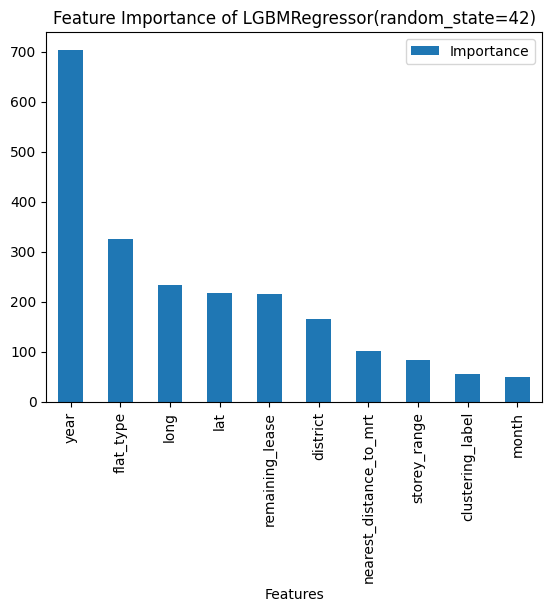

In [67]:
modelpipe_nofloorarea = Modelpipeline(df_test,'pca','dbscan', additional_features_out=['floor_area_sqm'])
modelpipe_nofloorarea.preprocess(training_size=0.5, split=False)
modelpipe_nofloorarea.train_model('lgbm')
modelpipe_nofloorarea.report_metrics()
modelpipe_nofloorarea.report_best_features(plot=True)

Inspecting Dataframe 
 Shape : (880195, 17)             
 First Row :          town flat_type flat_model  floor_area_sqm       street_name  \
0  ANG MO KIO    3 ROOM   Improved            69.0  ANG MO KIO AVE 4   

   resale_price    month  lease_commence_date storey_range block  \
0      147000.0  2000-01                 1986     07 TO 09   170   

  remaining_lease               address  \
0              85  170 ANG MO KIO AVE 4   

                                        full_address       lat        long  \
0  170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...  1.374001  103.836432   

  nearest_mrt  nearest_distance_to_mrt  
0   mayflower                    0.283   
 Columns : Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')
[('pca 1', 0.65

{'Mean Train RMSE': '28,831.291849784066',
 'Mean Val RMSE': '29,137.78894754804',
 'Model': LGBMRegressor(random_state=42)}


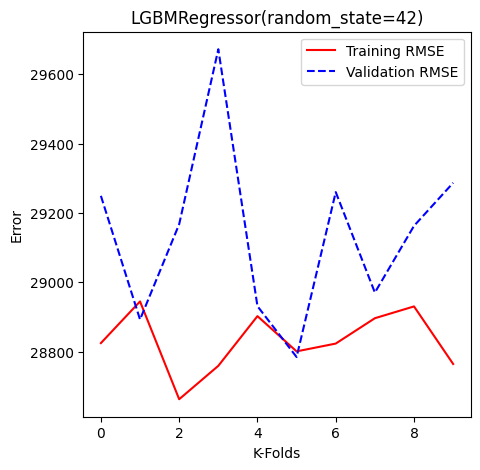

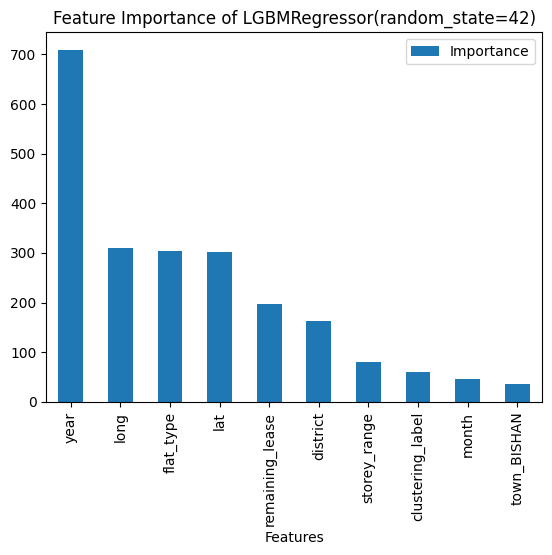

In [68]:
modelpipe_nofloorarea_nodistance = Modelpipeline(df_test,'pca','dbscan', additional_features_out=['floor_area_sqm', 'nearest_distance_to_mrt'])
modelpipe_nofloorarea_nodistance.preprocess(training_size=0.5, split=False)
modelpipe_nofloorarea_nodistance.train_model('lgbm')
modelpipe_nofloorarea_nodistance.report_metrics()
modelpipe_nofloorarea_nodistance.report_best_features(plot=True)

By eliminating some features we see that the performance of the model does not drop substantially even with important features like the floor area. It is most probably due to the large number of training samples that we have and I would think that flat type (2 room, 4 room, etc) may serve as a good proxy for it. We can see that when the floor area is removed, flat type is bumped up in importance for precisely that reason.

Inspecting Dataframe 
 Shape : (880195, 17)             
 First Row :          town flat_type flat_model  floor_area_sqm       street_name  \
0  ANG MO KIO    3 ROOM   Improved            69.0  ANG MO KIO AVE 4   

   resale_price    month  lease_commence_date storey_range block  \
0      147000.0  2000-01                 1986     07 TO 09   170   

  remaining_lease               address  \
0              85  170 ANG MO KIO AVE 4   

                                        full_address       lat        long  \
0  170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...  1.374001  103.836432   

  nearest_mrt  nearest_distance_to_mrt  
0   mayflower                    0.283   
 Columns : Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')
Inspect dataset

{'Mean Train RMSE': '26,667.15044180734',
 'Mean Val RMSE': '26,863.38080822274',
 'Model': LGBMRegressor(random_state=42)}


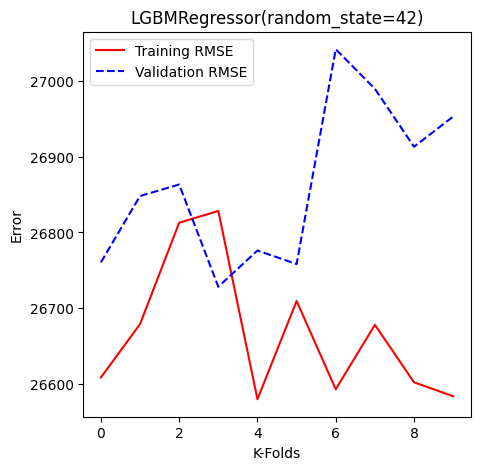

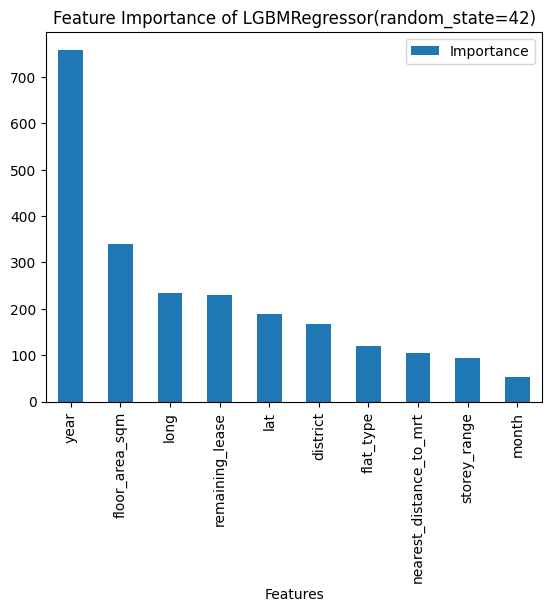

In [69]:
import numpy as np
params = {'max_bin': [200,250,300,350],
          'learning_rate': np.arange(0.1,0.5,0.2),
          'num_leaves': range(200,360,20),
         'random_state': [42]}
modelpipe = Modelpipeline(df_test)
modelpipe.preprocess(training_size=1, split=False)
modelpipe.train_model('lgbm')
modelpipe.report_metrics()
modelpipe.report_best_features(plot=True)

Training done, best params: {'learning_rate': 0.30000000000000004, 'max_bin': 350, 'num_leaves': 340, 'random_state': 42}


{'Mean Train RMSE': '17,098.99043852662',
 'Mean Val RMSE': '19,538.816049313617',
 'Model': LGBMRegressor(learning_rate=0.30000000000000004, max_bin=350, num_leaves=340,
              random_state=42)}


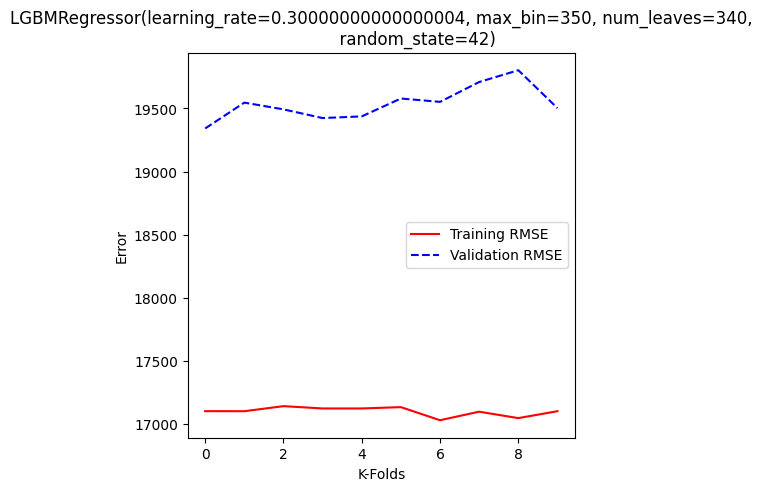

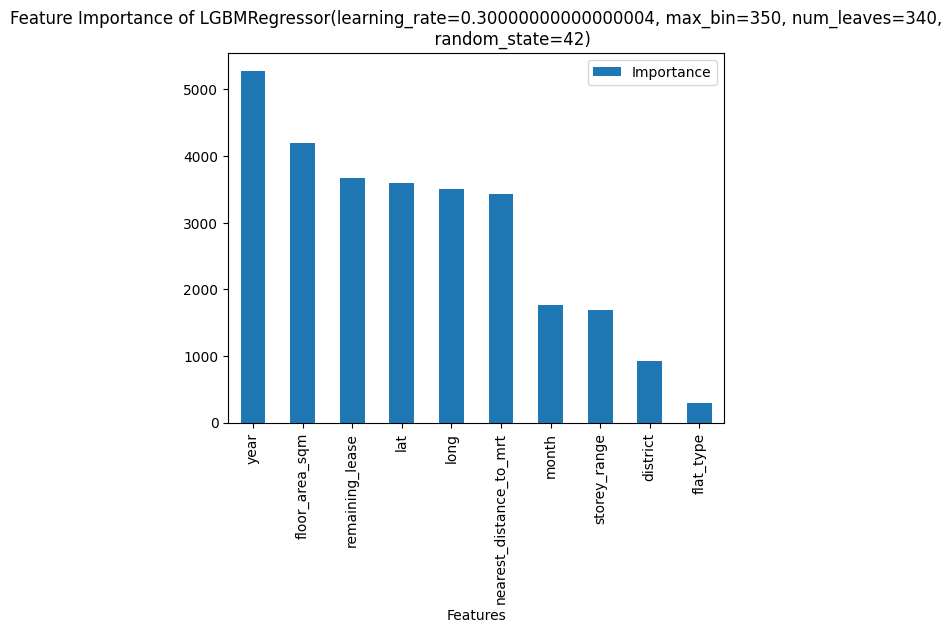

In [70]:
modelpipe.tune(params)
modelpipe.report_metrics()
modelpipe.report_best_features(plot=True)

In [71]:
modelpipe.save_model('tuned_lgbm_19k')

By tuning the hyperparameters of the model, we see that the validation RMSE has dropped significantly from 26K to 19K.

# Prediction

Inspecting Dataframe 
 Shape : (880195, 17)             
 First Row :          town flat_type flat_model  floor_area_sqm       street_name  \
0  ANG MO KIO    3 ROOM   Improved            69.0  ANG MO KIO AVE 4   

   resale_price    month  lease_commence_date storey_range block  \
0      147000.0  2000-01                 1986     07 TO 09   170   

  remaining_lease               address  \
0              85  170 ANG MO KIO AVE 4   

                                        full_address       lat        long  \
0  170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...  1.374001  103.836432   

  nearest_mrt  nearest_distance_to_mrt  
0   mayflower                    0.283   
 Columns : Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')
Inspect dataset

{'Mean Train RMSE': '15,920.649454417187',
 'Mean Val RMSE': '20,218.408997162012',
 'Model': LGBMRegressor(learning_rate=0.30000000000000004, max_bin=350, num_leaves=340,
              random_state=42)}


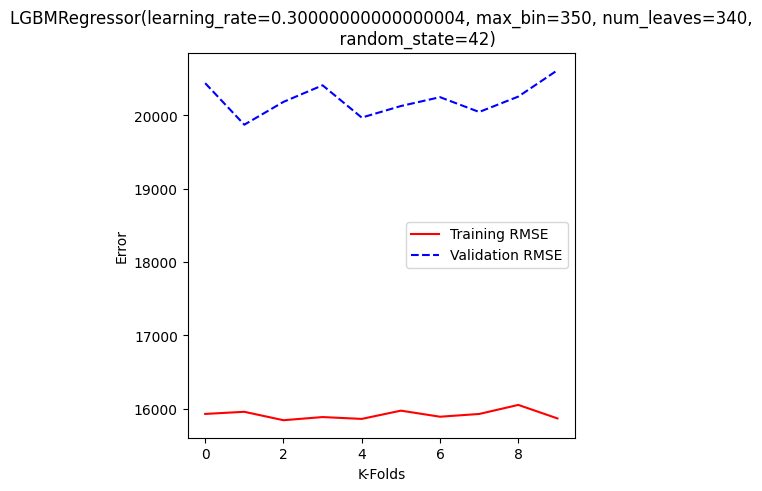

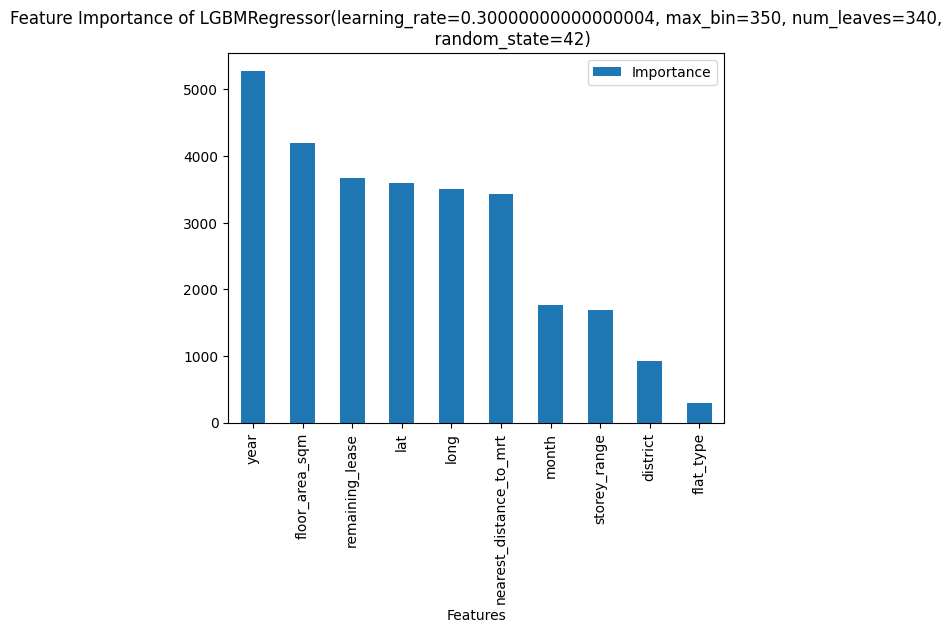

In [72]:
model_path = "tuned_lgbm_19k.pkl"
prediction_pipe = Modelpipeline(df_test)
prediction_pipe.preprocess(training_size=0.5, split=False)
prediction_pipe.load_model(model_path)
prediction_pipe.report_metrics()
prediction_pipe.report_best_features(plot=True)

In [73]:
test_input = test_df.iloc[[1,2],:]

In [74]:
test_input

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
594873,CHOA CHU KANG,4 ROOM,Model A,92.0,CHOA CHU KANG AVE 1,431800.0,2021-02,2017,01 TO 03,807B,95 years 03 months,807B CHOA CHU KANG AVE 1,807B CHOA CHU KANG AVENUE 1 KEAT HONG AXIS SIN...,1.376044,103.745171,south view,0.473
602757,ANG MO KIO,4 ROOM,NEW GENERATION,99.0,ANG MO KIO AVE 4,306000.0,1996-08,1978,04 TO 06,117,81,117 ANG MO KIO AVE 4,117 ANG MO KIO AVENUE 4 KEBUN BARU HEIGHTS SIN...,1.373717,103.835610,yio chu kang,1.370


In [75]:
test_labels = test_input['resale_price']

In [76]:
prediction_pipe.predict(test_input)

Input:                  town flat_type      flat_model  floor_area_sqm  \
594873  CHOA CHU KANG    4 ROOM         Model A            92.0   
602757     ANG MO KIO    4 ROOM  NEW GENERATION            99.0   

                street_name  resale_price    month  lease_commence_date  \
594873  CHOA CHU KANG AVE 1      431800.0  2021-02                 2017   
602757     ANG MO KIO AVE 4      306000.0  1996-08                 1978   

       storey_range block     remaining_lease                   address  \
594873     01 TO 03  807B  95 years 03 months  807B CHOA CHU KANG AVE 1   
602757     04 TO 06   117                  81      117 ANG MO KIO AVE 4   

                                             full_address       lat  \
594873  807B CHOA CHU KANG AVENUE 1 KEAT HONG AXIS SIN...  1.376044   
602757  117 ANG MO KIO AVENUE 4 KEBUN BARU HEIGHTS SIN...  1.373717   

              long   nearest_mrt  nearest_distance_to_mrt  
594873  103.745171    south view                    0.473  
60275

array([430866.06689274, 306311.12497944])

In [77]:
test_labels

594873    431800.0
602757    306000.0
Name: resale_price, dtype: float64

# Answer Pipeline

This section is mainly for taking in the input and then filling up the rest of the features

In [148]:
"""
Preprocess prediction input from user with minimal information

User will need to provide only the following data for inference:
- Postal Code
- Flat-type
- Storey-range

in order to provide the following
- nearest_mrt
- flat_model
- floor area sqm
- year, month : fixed to current year and month
- lat, long
- address
- full address
- Town
- street name
- lease commence date

"""

'\nPreprocess prediction input from user with minimal information\n\nUser will need to provide only the following data for inference:\n- Postal Code\n- Flat-type\n- Storey-range\n\nin order to provide the following\n- nearest_mrt\n- flat_model\n- floor area sqm\n- year, month : fixed to current year and month\n- lat, long\n- address\n- full address\n- Town\n- street name\n- lease commence date\n\n'

In [79]:
%load_ext autoreload
%autoreload 2

In [80]:
from hdb_mrt import hdb_mrt, hdb, mrt_onemap

c:\Users\Randy\GitHub\Predicting_HDB_Prices_withMRT_Dist\hdb_mrt\hdb_mrt.py:48: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="../conf/", config_name="config.yaml")


In [163]:
input = {
    'postal_code': 560325,
    'flat_type': '4 ROOM',
    'storey_range': '01 TO 05',
    'town': 'ANG MO KIO'
    }

In [96]:
from app.api.config import SETTINGS

In [97]:
import socket
import requests.packages.urllib3.util.connection as urllib3_cn
 
def allowed_gai_family():
    family = socket.AF_INET    # force IPv4
    return family
 
urllib3_cn.allowed_gai_family = allowed_gai_family

In [98]:
address = mrt_onemap.return_geo_one_address(one_map_url= SETTINGS.dict()['ONEMAP_API'], query= input['postal_code'])

In [99]:
address

{'address': '325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPORE 560325',
 'lat': 1.36789986956821,
 'long': 103.846887401387}

In [103]:
mrt_file = mrt_onemap.extract_mrt_excelsheet(SETTINGS.dict()['MRT_API'],
SETTINGS.dict()['MRT_EXCEL_FILE'])
mrt_stations_geo = mrt_onemap.return_mrt_with_geo(SETTINGS.dict()['ONEMAP_API'],mrt_file)

In [104]:
mrt_stations_geo

,station_name,stn_code,address,lat,long
0,jurong east,ns1,10 JURONG EAST STREET 12 JURONG EAST MRT STATI...,1.333153,103.742286
1,bukit batok,ns2,10 BUKIT BATOK CENTRAL BUKIT BATOK MRT STATION...,1.349033,103.749566
2,bukit gombak,ns3,802 BUKIT BATOK WEST AVENUE 5 BUKIT GOMBAK MRT...,1.358612,103.751791
3,choa chu kang,ns4,10 CHOA CHU KANG AVENUE 4 CHOA CHU KANG MRT ST...,1.385363,103.744371
4,yew tee,ns5,61 CHOA CHU KANG DRIVE YEW TEE MRT STATION (NS...,1.397535,103.747405
...,...,...,...,...,...
168,great world,te15,351 RIVER VALLEY ROAD GREAT WORLD MRT STATION ...,1.293948,103.833721
169,havelock,te16,110 ZION ROAD HAVELOCK MRT STATION (TE16) SING...,1.288505,103.833586
170,maxwell,te18,321 SOUTH BRIDGE ROAD MAXWELL MRT STATION (TE1...,1.280533,103.843884
171,shenton way,te19,2 PARK STREET SHENTON WAY MRT STATION (TE19) S...,1.277717,103.850368


In [117]:
query = pd.DataFrame.from_dict(address, orient='index').T

In [131]:
res = mrt_onemap.return_closest_mrt_distances(query.reset_index(), mrt_stations_geo)

In [132]:
res

,0,1,2,3,4,5
0,0,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373


In [160]:
columns = ['index','full_address', 'lat', 'long', 'nearest_mrt', 'nearest_distance_to_mrt']
res.columns = (columns)

In [161]:
lat = res.lat.values[0]
long = res.long.values[0]
nearest_mrt = res.nearest_mrt.values[0]
nearest_distance_to_mrt = res.nearest_distance_to_mrt.values[0]
full_address = res.full_address.values[0]

In [145]:
sample_data = df_test[(df_test.lat == lat) & (df_test.long == long) & (df_test.month.str.contains("20")) ].iloc[0,:]

In [147]:
sample_data

town                                                              ANG MO KIO
flat_type                                                             4 ROOM
flat_model                                                    New Generation
floor_area_sqm                                                          98.0
street_name                                                 ANG MO KIO AVE 3
resale_price                                                        252000.0
month                                                                2000-04
lease_commence_date                                                     1978
storey_range                                                        10 TO 12
block                                                                    325
remaining_lease                                                           77
address                                                 325 ANG MO KIO AVE 3
full_address               325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...

In [ ]:
"""
Preprocess prediction input from user with minimal information

User will need to provide only the following data for inference:
- Postal Code
- Flat-type
- Storey-range

in order to provide the following
- nearest_mrt
- flat_model
- floor area sqm
- year, month : fixed to current year and month
- lat, long
- address
- full address
- Town
- street name
- lease commence date

"""

In [165]:
from datetime import datetime

town = sample_data.town
flat_model = sample_data.flat_model
address = sample_data.address
floor_area_sqm = sample_data.floor_area_sqm
block = sample_data.block
year = datetime.now().year
month = f"{datetime.now():%Y-%m}"
street_name = sample_data.street_name
lease_commence_date = sample_data.lease_commence_date


In [166]:
test_df.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
799232,HOUGANG,5 ROOM,IMPROVED,122.0,HOUGANG AVE 8,346888.0,1998-04,1986,10 TO 12,630,87,630 HOUGANG AVE 8,630 HOUGANG AVENUE 8 SINGAPORE 530630,1.370286,103.881064,ang mo kio,3.503
594873,CHOA CHU KANG,4 ROOM,Model A,92.0,CHOA CHU KANG AVE 1,431800.0,2021-02,2017,01 TO 03,807B,95 years 03 months,807B CHOA CHU KANG AVE 1,807B CHOA CHU KANG AVENUE 1 KEAT HONG AXIS SIN...,1.376044,103.745171,south view,0.473
602757,ANG MO KIO,4 ROOM,NEW GENERATION,99.0,ANG MO KIO AVE 4,306000.0,1996-08,1978,04 TO 06,117,81,117 ANG MO KIO AVE 4,117 ANG MO KIO AVENUE 4 KEBUN BARU HEIGHTS SIN...,1.373717,103.835610,yio chu kang,1.370
688056,BEDOK,5 ROOM,STANDARD,118.0,BEDOK STH AVE 2,460000.0,1996-03,1978,07 TO 09,32,81,32 BEDOK STH AVE 2,32 BEDOK SOUTH AVENUE 2 SINGAPORE 460032,1.322626,103.937816,bedok,0.883
540253,WOODLANDS,4 ROOM,Premium Apartment,90.0,WOODLANDS DR 75,417000.0,2021-11,2004,01 TO 03,689B,81 years 04 months,689B WOODLANDS DR 75,689B WOODLANDS DRIVE 75 SINGAPORE 732689,1.444469,103.808397,admiralty,0.930


In [173]:
complete_res = {
    'town':town,
    'flat_type': input['flat_type'],
    'flat_model': flat_model,
    'floor_area_sqm': floor_area_sqm,
    'street_name': street_name,
    'resale_price': 0,
    'month': month,
    'lease_commence_date': lease_commence_date,
    'storey_range': input['storey_range'],
    'block': block, # sometimes the block is not in the full address or postal code
    'remaining_lease': year - lease_commence_date,
    'address': address,
    'full_address': full_address,
    'lat': lat,
    'long': long,
    'nearest_mrt': nearest_mrt,
    "nearest_distance_to_mrt": nearest_distance_to_mrt
}

In [174]:
complete_query = pd.DataFrame.from_dict(complete_res, orient='index').T

In [175]:
prediction_pipe.predict(complete_query)

CRITICAL:__main__:Input:          town flat_type      flat_model floor_area_sqm       street_name  \
0  ANG MO KIO    4 ROOM  New Generation           98.0  ANG MO KIO AVE 3   

  resale_price    month lease_commence_date storey_range block  \
0            0  2023-02                1978     01 TO 05   325   

  remaining_lease               address  \
0              45  325 ANG MO KIO AVE 3   

                                        full_address     lat        long  \
0  325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...  1.3679  103.846887   

  nearest_mrt nearest_distance_to_mrt  
0  ang mo kio                   0.373  
CRITICAL:__main__:Input transformed: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
  

array([507226.87495313])

Steps taken so far
- fetch MRT data
- computed MRT coordinates
- from resale hdb dataset, take existing record
- merge input with record fetched from dataset
- put into pandas dataframe
- call predict from pipeline

In [176]:
def return_mrt_with_geo(mrt_api:str,  one_map_url:str,mrt_excel_file:str )->pd.DataFrame:
    """
    returns a pandas dataframe of the mrt stations with geolocation

    columns:station_name, stn_code, address, lat ,long
    """
    mrt_file = mrt_onemap.extract_mrt_excelsheet(mrt_api,mrt_excel_file)
    mrt_stations_geo = mrt_onemap.return_mrt_with_geo(one_map_url,mrt_file)
    
    return mrt_stations_geo

In [177]:
input = {
    'postal_code': 644658,
    'flat_type': '4 ROOM',
    'storey_range': '01 TO 05'
    }

In [178]:
# fetch address from postal code
address = mrt_onemap.return_geo_one_address(one_map_url= SETTINGS.dict()['ONEMAP_API'], query= input['postal_code'])

mrt_stations_geo = return_mrt_with_geo(SETTINGS.dict()['MRT_API'],SETTINGS.dict()['ONEMAP_API'], SETTINGS.dict()['MRT_EXCEL_FILE'])
# format into pd DataFrame
query = pd.DataFrame.from_dict(address, orient='index').T

res = mrt_onemap.return_closest_mrt_distances(query.reset_index(), mrt_stations_geo)
columns = ['index','full_address', 'lat', 'long', 'nearest_mrt', 'nearest_distance_to_mrt']
res.columns = (columns)
lat = res.lat.values[0]
long = res.long.values[0]
nearest_mrt = res.nearest_mrt.values[0]
nearest_distance_to_mrt = res.nearest_distance_to_mrt.values[0]
full_address = res.full_address.values[0]
sample_data = df_test[(df_test.lat == lat) & (df_test.long == long) & (df_test.month.str.contains("20")) ].iloc[0,:]

from datetime import datetime

town = sample_data.town
flat_model = sample_data.flat_model
address = sample_data.address
floor_area_sqm = sample_data.floor_area_sqm
block = sample_data.block
year = datetime.now().year
month = f"{datetime.now():%Y-%m}"
street_name = sample_data.street_name
lease_commence_date = sample_data.lease_commence_date

complete_res = {
    'town':town,
    'flat_type': input['flat_type'],
    'flat_model': flat_model,
    'floor_area_sqm': floor_area_sqm,
    'street_name': street_name,
    'resale_price': 0,
    'month': month,
    'lease_commence_date': lease_commence_date,
    'storey_range': input['storey_range'],
    'block': block, # sometimes the block is not in the full address or postal code
    'remaining_lease': year - lease_commence_date,
    'address': address,
    'full_address': full_address,
    'lat': lat,
    'long': long,
    'nearest_mrt': nearest_mrt,
    "nearest_distance_to_mrt": nearest_distance_to_mrt
}

complete_query = pd.DataFrame.from_dict(complete_res, orient='index').T


In [179]:
prediction_pipe.predict(complete_query)

CRITICAL:__main__:Input:           town flat_type flat_model floor_area_sqm        street_name  \
0  JURONG WEST    4 ROOM   Improved          110.0  JURONG WEST ST 65   

  resale_price    month lease_commence_date storey_range block  \
0            0  2023-02                2001     01 TO 05  658D   

  remaining_lease                 address  \
0              22  658D JURONG WEST ST 65   

                                  full_address       lat        long  \
0  658D JURONG WEST STREET 65 SINGAPORE 644658  1.337217  103.700758   

  nearest_mrt nearest_distance_to_mrt  
0     pioneer                   0.384  
CRITICAL:__main__:Input transformed: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.       

array([493173.13246947])